In [1]:
from jax.experimental.optimizers import optimizer
import jax.numpy as np
import jax.scipy.stats as stats
from jax import random
import jax

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.flatten_util import ravel_pytree

import matplotlib.pylab as plt
import datetime

from jax.experimental import optimizers
import itertools
from time import time
import numpy

from dense_nn import baoab

# Testing the sampling infrastructure on a known task:
## Estimation of success probability in repeated Bernoulli trials

The goal is to estimate the probability of success from data where the number of trials is recorded as are the number of successes. With a conjugate prior, the posterior distribution (and its moments) are known. Alternatively, I could sample from the posterior with my Langevin integrator. The empirical moments from the integrator should match the true posterior if my model framework and integrator are correct.

## Set-up the model

In [2]:
# The data. The smaller the probability of sucess, the smaller the timestep required.
KSUCCESSES = 5

# Prior parameters: a uniform distribution
ALPHA=1
BETA=1

POST_ALPHA = ALPHA + KSUCCESSES 
POST_BETA = BETA + NTRIALS - KSUCCESSES

# Bionomial likelihood:
@jit
def log_like(x):
    return KSUCCESSES*np.log(x) + (NTRIALS-KSUCCESSES)*np.log(1 - x)

# Bionomial Prior, which is conjugate to the likelihood.
@jit
def log_prior(x):
    return stats.beta.logpdf(x, a=ALPHA, b=BETA)

@jit
def energy(x):
    return -log_like(x) - log_prior(x)

energy_gradient_fun = jit(grad(energy))

## Burn-in
Stabilizing the system with a high coefficient of friction (gamma). 

In [3]:
# Length of simulation and when to save stats
nsteps = 15000
save_freq = 1
percent = 10
completion_freq = int(nsteps/percent)

# Initialize random seed
seed = datetime.datetime.now().microsecond
key = random.PRNGKey(seed)
split_keys = random.split(key, nsteps)

# Initialize params
unknowns = random.uniform(key, (1,))
momenta = random.normal(key, (1,)) 

# Initialize integrator
step = baoab(0.001, mass=10, gamma=10)

trace = []
trace_energy = []
start_time = time()
k = 0.
for i in range(nsteps):
    g = energy_gradient_fun(unknowns[0])
    unknowns, momenta = step(g, unknowns, momenta, split_keys[i])
    if i % save_freq == 0:
        trace.append(unknowns[0])
        trace_energy.append(energy(unknowns))
    if i % completion_freq == 0:
        print('{0}% completed.'.format(k*percent))
        k += 1
print('100% completed.')
print('time =', time() - start_time)

/Users/ross/miniconda3/envs/bayesnn/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


0.0% completed.
10.0% completed.
20.0% completed.
30.0% completed.
40.0% completed.
50.0% completed.
60.0% completed.
70.0% completed.
80.0% completed.
90.0% completed.
100% completed.
time = 63.906962871551514


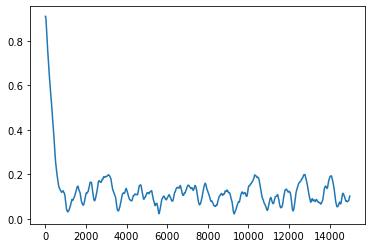

In [4]:
trace = np.hstack(trace)
plt.plot(trace)
plt.show()

## Production

In [5]:
# Length of simulation and when to save stats
nsteps = 15000
save_freq = 1
percent = 10
completion_freq = int(nsteps/percent)

# Initialize random seed
seed = datetime.datetime.now().microsecond
key = random.PRNGKey(seed)
split_keys = random.split(key, nsteps)


# Initialize integrator
step = baoab(0.001, mass=1, gamma=10)

trace = []
trace_energy = []
start_time = time()
k = 0.
for i in range(nsteps):
    g = energy_gradient_fun(unknowns[0])
    unknowns, momenta = step(g, unknowns, momenta, split_keys[i])
    if i % save_freq == 0:
        trace.append(unknowns[0])
        trace_energy.append(energy(unknowns))
    if i % completion_freq == 0:
        print('{0}% completed.'.format(k*percent))
        k += 1
print('100% completed.')
print('time =', time() - start_time)

0.0% completed.
10.0% completed.
20.0% completed.
30.0% completed.
40.0% completed.
50.0% completed.
60.0% completed.
70.0% completed.
80.0% completed.
90.0% completed.
100% completed.
time = 63.12924313545227


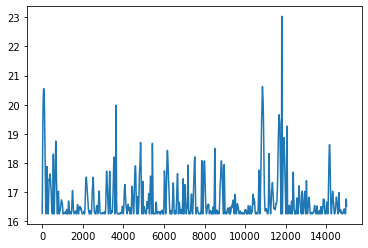

In [6]:
trace_energy = np.hstack(trace_energy)
plt.plot(trace_energy)
plt.show()

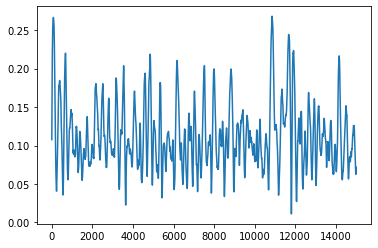

In [7]:
trace = np.hstack(trace)
plt.plot(trace)
plt.show()

In [8]:
print('Empirical expected probability of success =', trace[50:].mean())
print('True posterior probability of success =', POST_ALPHA/(POST_ALPHA + POST_BETA))

Empirical expected probability of success = 0.112077415
True posterior probability of success = 0.11538461538461539
